# NeuralHash Classifier

This is a classifier for an output of Apple's [NeuralHash](https://www.apple.com/child-safety/pdf/CSAM_Detection_Technical_Summary.pdf) function.

The model is trained on the [NeuralHash of ILSVRC2012 dataset](https://github.com/kjsman/NeuralHash-Classifier/releases/tag/t).

Performance on the ImageNet validation dataset: (1,000 possible choices)
- Top-1 Accuracy:  5.25% (0.1%, if random)
- Top-5 Accuracy: 14.09% (0.5%, if random)

Now if you think Apple's NeuralHash is defective, please consider signing [an Open Letter Against Apple's Privacy-Invasive Content Scanning Technology](https://appleprivacyletter.com/).

In [1]:
# @title Licensed under the MIT License.

# Copyright (c) 2021 Jinseo Kim

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
#@title Setup (~20 seconds)
!wget -q "https://unsplash.com/photos/P9p2MJLMqlo/download?force=true&w=640" -O "cute_dog.jpg"
!wget -q "https://github.com/kjsman/NeuralHash-Classifier/releases/download/models/imagenet1000_clsidx_to_labels.txt"
!wget -q "https://github.com/kjsman/NeuralHash-Classifier/releases/download/models/neuralhash.onnx"
!wget -q "https://github.com/kjsman/NeuralHash-Classifier/releases/download/models/oc.onnx"
!wget -q "https://github.com/kjsman/NeuralHash-Classifier/releases/download/models/seed.npy"
%pip install -q onnxruntime

import onnxruntime
import numpy as np
from PIL import Image

import requests
from ast import literal_eval
from google.colab import files

hash_session = onnxruntime.InferenceSession("neuralhash.onnx")
oc_session = onnxruntime.InferenceSession("oc.onnx")
seed = np.load('seed.npy')

with open('imagenet1000_clsidx_to_labels.txt') as f:
    idx2name = literal_eval(f.read())

print("Setup finished!")

     |████████████████████████████████| 4.5 MB 5.0 MB/s 
Setup finished!


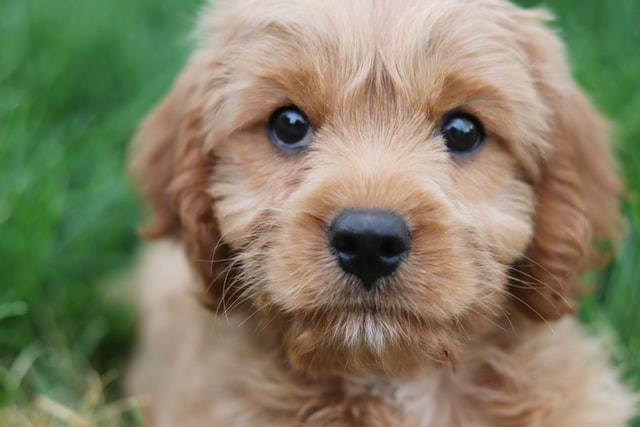


NeuralHash: 2273310f003ae9db0c3ff2f2


In [3]:
#@title NeuralHash (~3 seconds)
Method = "Sample image" #@param ['Upload image', 'Enter image URL', 'Sample image']

if Method == 'Upload image':
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
    im = Image.open(image_path)
elif Method == 'Enter image URL':
    image_url = input("Enter image URL: ")
    im = Image.open(requests.get(image_url, stream=True).raw)
elif Method == 'Sample image':
    im = Image.open('cute_dog.jpg')

display(im)

im = im.resize([360, 360]).convert('RGB')
arr = np.array(im).astype(np.float32) / 255.0
arr = arr * 2.0 - 1.0
arr = arr.transpose(2, 0, 1).reshape([1, 3, 360, 360])

# Run model
inputs = {hash_session.get_inputs()[0].name: arr}
outs = hash_session.run(None, inputs)

# Convert model output to hex hash
hash_output = seed.dot(outs[0].flatten())
hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)

print()
print("NeuralHash:", hash_hex)

In [4]:
#@title Classification (~3 seconds)
NeuralHash = "2273310f003ae9db0c3ff2f2" #@param {type: 'string'}

hex_digits = set("0123456789abcdefABCDEF")
if len(NeuralHash) != 24 or not all(c in hex_digits for c in NeuralHash):
    raise ValueError("NeuralHash hash must be 12 bytes (24 chars) hexademical string")

data = np.unpackbits(np.frombuffer(bytes.fromhex(NeuralHash), dtype=np.uint8)).reshape((-1, 96)).astype(np.float32)

inputs = {oc_session.get_inputs()[0].name: data}
outs = oc_session.run(None, inputs)

result = np.argsort(-outs[0][0])[:10]

names = map(lambda x: idx2name[x], result)
probs = (outs[0][0][result] * 100).tolist()
pretty_result = map(lambda x: f"({x[1]:5.2f}%) {x[0]}", zip(names, probs))
print('\n'.join(pretty_result))

(14.17%) Dandie Dinmont, Dandie Dinmont terrier
( 5.98%) Maltese dog, Maltese terrier, Maltese
( 4.88%) golden retriever
( 3.86%) lemon
( 2.87%) Granny Smith
( 2.66%) butternut squash
( 2.30%) clumber, clumber spaniel
( 2.15%) Lhasa, Lhasa apso
( 1.95%) orange
( 1.79%) miniature poodle
